In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

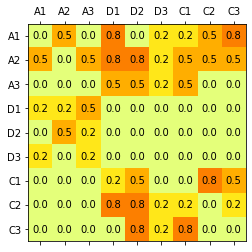

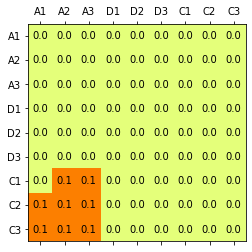

In [2]:
#----------Libraries---------------
import numpy as np
import os
import matplotlib.pyplot as plt
#----------Creating, Pruning MDM---------------

#Creating random MDM:
strength_values = [0, 0.2, 0.5, 0.8]
MDM = np.random.choice(strength_values, size = (9, 9), replace = True)

#Pruning:
np.fill_diagonal(MDM, 0)
MDM[3:6, 3:9] = 0
MDM[6:9, 0:3] = 0

#creating empty Combined Likelihood:
CL = np.zeros((9, 9))
#----------Functions---------------

#The function that changes the name of each cell into the relationship names(just for better visualization)
def name(i, j):
    maatrix_names = np.array([
        ["A1-A1", "A2-A1", 'A3-A1', 'D1-A1', 'D2-A1', 'D3-A1', 'C1-A1', 'C2-A1', 'C3-A1'],
        ["A1-A2", "A2-A2", 'A3-A2', 'D1-A2', 'D2-A2', 'D3-A2', 'C1-A2', 'C2-A2', 'C3-A2'],
        ["A1-A3", "A2-A3", 'A3-A3', 'D1-A3', 'D2-A3', 'D3-A3', 'C1-A3', 'C2-A3', 'C3-A3'],
        ["A1-D1", "A2-D1", 'A3-D1', 'D1-D1', 'D2-D1', 'D3-D1', 'C1-D1', 'C2-D1', 'C3-D1'],
        ["A1-D2", "A2-D2", 'A3-D2', 'D1-D2', 'D2-D2', 'D3-D2', 'C1-D2', 'C2-D2', 'C3-D2'],
        ["A1-D3", "A2-D3", 'A3-D3', 'D1-D3', 'D2-D3', 'D3-D3', 'C1-D3', 'C2-D3', 'C3-D3'],
        ["A1-C1", "A2-C1", 'A3-C1', 'D1-C1', 'D2-C1', 'D3-C1', 'C1-C1', 'C2-C1', 'C3-C1'],
        ["A1-C2", "A2-C2", 'A3-C2', 'D1-C2', 'D2-C2', 'D3-C2', 'C1-C2', 'C2-C2', 'C3-C2'],
        ["A1-C3", "A2-C3", 'A3-C3', 'D1-C3', 'D2-C3', 'D3-C3', 'C1-C3', 'C2-C3', 'C3-C3']
    ])
    return maatrix_names[i, j]


#The function that is used for Computimg Component level aggregation (Probanilities: P(A|D, C, ...)):
def component_level(list):
    P = []
    Prob = 1
    for i in range(len(list)):
        Prob *= MDM[(*list[i], )]
        #beacuse MDM[[1, 3]] != MDM[1, 3], however equals MDM[(1, 3)]
    P.append(Prob)
    return P

#The function that is used for Computimg Route level aggregation:
def route_level(list):
    if len(list) == 0:
        return 0
    else:
        route_level = 0
        for i in range(len(list)):
            route_level += np.power(list[i], len(list))
    return np.power(route_level, 1/(len(list)))

#The function that normalize a matrix to (0, 1)
def normalizer(matrix):
    matrixmax, matrixmin = matrix.max(), matrix.min()
    a = matrix - matrixmin
    b = matrixmax - matrixmin
    matrix = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    return matrix

#The function to Compute Compound Impact:
def CI(matrix):
    outgoing = matrix.sum(axis = 0)
    ingoing = matrix.sum(axis = 1)
    CR_NN = np.divide(outgoing, ingoing, out=np.zeros_like(outgoing), where=ingoing!=0)
    CR = (normalizer(CR_NN)* 0.6) + 0.2

    return CR.reshape(len(matrix), 1)

#The function to Compute Combined Risk:
def CR(matrix_CL , matrix_CI):
    return matrix_CL * matrix_CI

#The function to plot Matrices:
def plot(matrix):
    matrix = np.round(matrix, 1)
    fig, ax = plt.subplots()
    min_val, max_val = 0, 9
    intersection_matrix = matrix
    ax.matshow(matrix, cmap=plt.cm.Wistia)
    for i in range(9):
        for j in range(9):
            c = intersection_matrix[j,i]
            ax.text(i, j, str(c), va='center', ha='center')

    labels = plt.xticks()
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['A1', 'A2', 'A3', 'D1', 'D2', 'D3', 'C1', 'C2', 'C3'])
    labels = plt.yticks()  # Get the current locations and labels.
    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['A1', 'A2', 'A3', 'D1', 'D2', 'D3', 'C1', 'C2', 'C3'])
#----------#Creating Agents to Consequences Routes,Paths ---------------


#There are 3 possible routes: 1) A-D-C 2) A-A-D-D 3)A-D-C-C:

#First Route: Creating all Paths for route 1) A-D-C : (All agents to All Consequences through all Decisions)
route_adc = []
route_adc_name = []
for k in range(3):
    for j in range(3):
        for i in range(3):
            if (MDM[i+3, j] !=0) & (MDM[6+k, i+3] != 0):
                route_adc_name.append([name(i+3, j), name(6+k, i+3)])
                route_adc.append([[i+3, j], [6+k, i+3]])

#2nd Route: Creating all Paths for route 2) A-A-D-C :
route_aadc_name = []
route_aadc = []
for h in range(3):
    for k in range(3):
        for i in range(3):
            for j in range(3):
                if (MDM[i, k] != 0) & (MDM[j+3, i] != 0) & (MDM[h+6, j+3] != 0):
                    route_aadc_name.append([name(i, k), name(j+3, i), name(h+6, j+3)])
                    route_aadc.append([[i, k], [j+3, i], [h+6, j+3]])

#3rd Route: Creating all Paths for route 3) A-D-C-C :
route_adcc = []
route_adcc_name = []
for h in range(3):
    for k in range(3):
        for i in range(3):
            for j in range(3):
                if (MDM[i+3, k] != 0) & (MDM[j+6, i+3] != 0) & (MDM[h+6, j+6] != 0):
                    route_adcc_name.append([name(i+3, k), name(j+6, i+3), name(h+6, j+6)])
                    route_adcc.append([[i+3, k], [j+6, i+3], [h+6, j+6]])


#------------Computing Combined Likelihood matrix for all Agent to Consequences cells:------
for x in range(3):
    for y in range(3):
        list_Probs_adc = []
        for i in range(len(route_adc)):
            if (route_adc[i][0][1] == x) & (route_adc[i][-1][0] == y+6):
                Prob = component_level(route_adc[i])
                list_Probs_adc.append(Prob)

        list_Probs_aadc = []
        for i in range(len(route_aadc)):
            if (route_aadc[i][0][1] == x) & (route_aadc[i][-1][0] == y+6):
                Prob = component_level(route_aadc[i])
                list_Probs_aadc.append(Prob)


        list_Probs_adcc = []
        Prob = 1
        for i in range(len(route_adcc)):
            if (route_adcc[i][0][1] == x) & (route_adcc[i][-1][0] == y+6):
                Prob = component_level(route_adcc[i])
                list_Probs_adcc.append(Prob)


        CLAC = (np.power(route_level(list_Probs_adc), 3) + np.power(route_level(list_Probs_aadc), 3) +
        np.power(route_level(list_Probs_adcc), 3))**(1/3)
        CL[y+6, x] = CLAC

#----Computing the final Combined risk matrix: CR = CL * CI
Combined_risk = CR(CL, CI(MDM))
plot(MDM)
plot(Combined_risk)